In [1]:
from demodq.datasets import Datasets
from demodq.column_errors import detect_missing_values, detect_outliers_sd, detect_outliers_iqr
from demodq.tuple_errors import detect_mislabeled_via_cleanlab, detect_outliers_via_if, detect_mislabeled_via_shapley
from demodq.analysis import analyse_marked, detect_disparate_errors, is_disparate

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

def perc(frac):
    if frac == np.NAN: return frac
    return str(round(frac * 100, 1)) + '\%'

In [3]:
import pandas as pd

cases = [('adult', 'sex', 'race'), ('folktables', 'sex', 'race'), 
         ('heart', 'sex', 'age@45'), ('heart', 'sex', 'age@55'),  # TODO: Move heart to last position
         ('german', 'age', 'sex'), ('german', 'age', 'foreign_worker'), ('german', 'sex', 'foreign_worker')]

Set up streamlined workflow for SQL analysis with DuckDB. ([example notebook in Colab](https://colab.research.google.com/drive/1eOA2FYHqEfZWLYssbUxdIpSL3PFxWVjk?usp=sharing#scrollTo=vQivFMys2vtz))

In [4]:
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Configure jupysql to return data as a Pandas dataframe and have less verbose output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect jupysql to in-memory DuckDB database
%sql duckdb:///:memory:

In [5]:
%%sql
CREATE TABLE groups(
    dataset VARCHAR,
    attr1 VARCHAR,
    attr2 VARCHAR,
    pp_count INTEGER,
    pd_count INTEGER,
    dp_count INTEGER,
    dd_count INTEGER,
    PRIMARY KEY(dataset, attr1, attr2));

CREATE TABLE errors(
    dataset VARCHAR,
    attr1 VARCHAR,
    attr2 VARCHAR,
    error_type VARCHAR,
    pp_dirty INTEGER,
    pd_dirty INTEGER,
    dp_dirty INTEGER,
    dd_dirty INTEGER,
    PRIMARY KEY(dataset, attr1, attr2, error_type));

""


In [6]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    dirty_slices = []

    for column in dataset.categorical_columns + dataset.numerical_columns:
        dirty_slices.append(detect_missing_values(data, column))

    dirty = pd.concat(dirty_slices).drop_duplicates(subset='id')

    data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
        dataset.partition_data_by(data, attr1, attr2)
    dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
        dataset.partition_data_by(dirty, attr1, attr2)

    query = f"INSERT INTO groups VALUES ('{dataset_name}', '{attr1}', '{attr2}', "\
            f"{len(data_priv_priv)}, {len(data_priv_nonpriv)}, "\
            f"{len(data_nonpriv_priv)}, {len(data_nonpriv_nonpriv)})"
    %sql {{query}}

    # disparate = is_disparate(len(data_priv), len(dirty_priv), len(data_nonpriv), len(dirty_nonpriv))
    
    # frac_priv_priv = len(dirty_priv_priv) / len(data_priv_priv) if len(data_priv_priv) else np.NAN
    # frac_priv_nonpriv = len(dirty_priv_nonpriv) / len(data_priv_nonpriv) if len(data_priv_nonpriv) else np.NAN
    # frac_nonpriv_priv = len(dirty_nonpriv_priv) / len(data_nonpriv_priv) if len(data_nonpriv_priv) else np.NAN
    # frac_nonpriv_nonpriv = len(dirty_nonpriv_nonpriv) / len(data_nonpriv_nonpriv) if len(data_nonpriv_nonpriv) else np.NAN

    query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'missing-values',"\
            f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
            f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)})"
    %sql {{query}}

In [7]:
%sql SELECT * FROM groups

,dataset,attr1,attr2,pp_count,pd_count,dp_count,dd_count
0,adult,sex,race,28735,3915,13027,3165
1,folktables,sex,race,115136,71541,117473,74667
2,heart,sex,age@45,39163,6367,20565,3905
3,heart,sex,age@55,20579,10674,24951,13796
4,german,age,sex,605,205,85,105
5,german,age,foreign_worker,34,776,3,187
6,german,sex,foreign_worker,30,660,7,303


In [8]:
%sql SELECT * FROM errors WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,pp_dirty,pd_dirty,dp_dirty,dd_dirty
0,adult,sex,race,missing-values,1715,408,1144,353
1,folktables,sex,race,missing-values,50027,32841,60974,38371
2,heart,sex,age@45,missing-values,0,0,0,0
3,heart,sex,age@55,missing-values,0,0,0,0
4,german,age,sex,missing-values,208,58,18,21
5,german,age,foreign_worker,missing-values,8,258,1,38
6,german,sex,foreign_worker,missing-values,7,219,2,77


In [9]:
%%sql --save group_error_rates --no-execute
SELECT
    e.dataset, e.attr1, e.attr2, e.error_type,

    pp_dirty/pp_count AS pp_dirty__pp_count,
    pp_count,
    pp_count/total_count AS pp_count__total_count,
    pp_dirty/total_dirty AS pp_dirty__total_dirty,

    pd_dirty/pd_count AS pd_dirty__pd_count,
    pd_count,
    pd_count/total_count AS pd_count__total_count,
    pd_dirty/total_dirty AS pd_dirty__total_dirty,

    dp_dirty/dp_count AS dp_dirty__dp_count,
    dp_count,
    dp_count/total_count AS dp_count__total_count,
    dp_dirty/total_dirty AS dp_dirty__total_dirty,

    dd_dirty/dd_count AS dd_dirty__dd_count,
    dd_count,
    dd_count/total_count AS dd_count__total_count,
    dd_dirty/total_dirty AS dd_dirty__total_dirty,

    (pp_dirty + pd_dirty + dp_dirty) / (pp_count + pd_count + dp_count) AS pagg_dirty__pagg_count,
    (pp_count + pd_count + dp_count) AS pagg_count,
    (pp_count + pd_count + dp_count) / total_count AS pagg_count__total_count,
    (pp_dirty + pd_dirty + dp_dirty) / total_dirty AS pagg_dirty__total_dirty,

    (pd_dirty + dp_dirty + dd_dirty) / (pd_count + dp_count + dd_count) AS dagg_dirty__dagg_count,
    (pd_count + dp_count + dd_count) AS dagg_count,
    (pd_count + dp_count + dd_count) / total_count AS dagg_count__total_count,
    (pd_dirty + dp_dirty + dd_dirty) / total_dirty AS dagg_dirty__total_dirty,
FROM (
    SELECT
        dataset, attr1, attr2, error_type,
        pp_dirty, pd_dirty, dp_dirty, dd_dirty,
        (pp_dirty + pd_dirty + dp_dirty + dd_dirty) AS total_dirty,
    FROM errors
) e
JOIN (
    SELECT
        dataset, attr1, attr2,
        pp_count, pd_count, dp_count, dd_count,
        (pp_count + pd_count + dp_count + dd_count) AS total_count,
    FROM groups
) g
ON g.dataset = e.dataset AND g.attr1 = e.attr1 AND g.attr2 = e.attr2

Skipping execution...

In [10]:
%%sql --save error_rates__pp_dd --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pp_dirty__pp_count AS priv_dirty__priv_count,
    pp_count AS priv_count,
    pp_count__total_count AS priv_count__total_count,
    pp_dirty__total_dirty AS priv_dirty__total_dirty,
    dd_dirty__dd_count AS dis_dirty__dis_count,
    dd_count AS dis_count,
    dd_count__total_count AS dis_count__total_count,
    dd_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [11]:
%%sql --save error_rates__pagg_dd --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pagg_dirty__pagg_count AS priv_dirty__priv_count,
    pagg_count AS priv_count,
    pagg_count__total_count AS priv_count__total_count,
    pagg_dirty__total_dirty AS priv_dirty__total_dirty,
    dd_dirty__dd_count AS dis_dirty__dis_count,
    dd_count AS dis_count,
    dd_count__total_count AS dis_count__total_count,
    dd_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [12]:
%%sql --save error_rates__pp_dagg --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pp_dirty__pp_count AS priv_dirty__priv_count,
    pagg_count AS priv_count,
    pagg_count__total_count AS priv_count__total_count,
    pagg_dirty__total_dirty AS priv_dirty__total_dirty,
    dagg_dirty__dagg_count AS dis_dirty__dis_count,
    dagg_count AS dis_count,
    dagg_count__total_count AS dis_count__total_count,
    dagg_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [13]:
%%sql --save missing_values__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.059683,28735,0.588326,0.473757,0.111532,3165,0.064801,0.097514
1,folktables,sex,race,missing-values,0.434504,115136,0.303936,0.274552,0.513895,74667,0.197106,0.210583
2,heart,sex,age@45,missing-values,0.000000,39163,0.559471,NaN,0.000000,3905,0.055786,NaN
3,heart,sex,age@55,missing-values,0.000000,20579,0.293986,NaN,0.000000,13796,0.197086,NaN
4,german,age,sex,missing-values,0.343802,605,0.605000,0.681967,0.200000,105,0.105000,0.068852
5,german,age,foreign_worker,missing-values,0.235294,34,0.034000,0.026230,0.203209,187,0.187000,0.124590
6,german,sex,foreign_worker,missing-values,0.233333,30,0.030000,0.022951,0.254125,303,0.303000,0.252459


In [14]:
%%sql --save missing_values__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.071524,45677,0.935199,0.902486,0.111532,3165,0.064801,0.097514
1,folktables,sex,race,missing-values,0.472931,304150,0.802894,0.789417,0.513895,74667,0.197106,0.210583
2,heart,sex,age@45,missing-values,0.000000,66095,0.944214,NaN,0.000000,3905,0.055786,NaN
3,heart,sex,age@55,missing-values,0.000000,56204,0.802914,NaN,0.000000,13796,0.197086,NaN
4,german,age,sex,missing-values,0.317318,895,0.895000,0.931148,0.200000,105,0.105000,0.068852
5,german,age,foreign_worker,missing-values,0.328413,813,0.813000,0.875410,0.203209,187,0.187000,0.124590
6,german,sex,foreign_worker,missing-values,0.327116,697,0.697000,0.747541,0.254125,303,0.303000,0.252459


In [15]:
%%sql --save missing_values__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.059683,45677,0.935199,0.902486,0.094743,20107,0.411674,0.526243
1,folktables,sex,race,missing-values,0.434504,304150,0.802894,0.789417,0.501310,263681,0.696064,0.725448
2,heart,sex,age@45,missing-values,0.000000,66095,0.944214,NaN,0.000000,30837,0.440529,NaN
3,heart,sex,age@55,missing-values,0.000000,56204,0.802914,NaN,0.000000,49421,0.706014,NaN
4,german,age,sex,missing-values,0.343802,895,0.895000,0.931148,0.245570,395,0.395000,0.318033
5,german,age,foreign_worker,missing-values,0.235294,813,0.813000,0.875410,0.307453,966,0.966000,0.973770
6,german,sex,foreign_worker,missing-values,0.233333,697,0.697000,0.747541,0.307216,970,0.970000,0.977049


In [16]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    for detector, name in [(detect_outliers_sd, 'sd'), (detect_outliers_iqr, 'iqr')]:
        dirty_slices = []

        for column in dataset.numerical_columns:
            dirty_slices.append(detector(data, column))

        dirty = pd.concat(dirty_slices).drop_duplicates(subset='id')

        data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
            dataset.partition_data_by(data, attr1, attr2)
        dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
            dataset.partition_data_by(dirty, attr1, attr2)

        # disparate = is_disparate(len(data_priv), len(dirty_priv), len(data_nonpriv), len(dirty_nonpriv))

        # frac_priv_priv = len(dirty_priv_priv) / len(data_priv_priv) if len(data_priv_priv) else np.NAN
        # frac_priv_nonpriv = len(dirty_priv_nonpriv) / len(data_priv_nonpriv) if len(data_priv_nonpriv) else np.NAN
        # frac_nonpriv_priv = len(dirty_nonpriv_priv) / len(data_nonpriv_priv) if len(data_nonpriv_priv) else np.NAN
        # frac_nonpriv_nonpriv = len(dirty_nonpriv_nonpriv) / len(data_nonpriv_nonpriv) if len(data_nonpriv_nonpriv) else np.NAN

        query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'outliers-{name}',"\
                f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
                f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)})"
        %sql {{query}}

    # Isolation Forest
    dirty = detect_outliers_via_if(data, dataset, 1234)  # TODO: Try different seeds

    dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
        dataset.partition_data_by(dirty, attr1, attr2)

    # frac_priv_priv = len(dirty_priv_priv) / len(data_priv_priv) if len(data_priv_priv) else np.NAN
    # frac_priv_nonpriv = len(dirty_priv_nonpriv) / len(data_priv_nonpriv) if len(data_priv_nonpriv) else np.NAN
    # frac_nonpriv_priv = len(dirty_nonpriv_priv) / len(data_nonpriv_priv) if len(data_nonpriv_priv) else np.NAN
    # frac_nonpriv_nonpriv = len(dirty_nonpriv_nonpriv) / len(data_nonpriv_nonpriv) if len(data_nonpriv_nonpriv) else np.NAN

    query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'outliers-if',"\
            f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
            f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)})"
    %sql {{query}}

In [17]:
%%sql --save outliers__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.080773,28735,0.588326,0.694079,0.037599,3165,0.064801,0.035586
1,adult,sex,race,outliers-iqr,0.372159,28735,0.588326,0.587066,0.310269,3165,0.064801,0.053909
2,adult,sex,race,outliers-if,0.000557,28735,0.588326,0.032720,0.088784,3165,0.064801,0.574642
3,folktables,sex,race,outliers-sd,0.006957,115136,0.303936,0.424483,0.004179,74667,0.197106,0.165342
4,folktables,sex,race,outliers-iqr,0.000000,115136,0.303936,NaN,0.000000,74667,0.197106,NaN
5,folktables,sex,race,outliers-if,0.002597,115136,0.303936,0.078913,0.022272,74667,0.197106,0.438902
6,heart,sex,age@45,outliers-sd,0.108495,39163,0.559471,0.601586,0.068374,3905,0.055786,0.037803
7,heart,sex,age@45,outliers-iqr,0.243189,39163,0.559471,0.573908,0.180538,3905,0.055786,0.042483
8,heart,sex,age@45,outliers-if,0.004392,39163,0.559471,0.245714,0.023303,3905,0.055786,0.130000
9,heart,sex,age@55,outliers-sd,0.129452,20579,0.293986,0.377177,0.083792,13796,0.197086,0.163670


In [18]:
%%sql --save outliers__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.070604,45677,0.935199,0.964414,0.037599,3165,0.064801,0.035586
1,adult,sex,race,outliers-iqr,0.377301,45677,0.935199,0.946091,0.310269,3165,0.064801,0.053909
2,adult,sex,race,outliers-if,0.004554,45677,0.935199,0.425358,0.088784,3165,0.064801,0.574642
3,folktables,sex,race,outliers-sd,0.005178,304150,0.802894,0.834658,0.004179,74667,0.197106,0.165342
4,folktables,sex,race,outliers-iqr,0.000000,304150,0.802894,NaN,0.000000,74667,0.197106,NaN
5,folktables,sex,race,outliers-if,0.006990,304150,0.802894,0.561098,0.022272,74667,0.197106,0.438902
6,heart,sex,age@45,outliers-sd,0.102822,66095,0.944214,0.962197,0.068374,3905,0.055786,0.037803
7,heart,sex,age@45,outliers-iqr,0.240412,66095,0.944214,0.957517,0.180538,3905,0.055786,0.042483
8,heart,sex,age@45,outliers-if,0.009214,66095,0.944214,0.870000,0.023303,3905,0.055786,0.130000
9,heart,sex,age@55,outliers-sd,0.105099,56204,0.802914,0.836330,0.083792,13796,0.197086,0.163670


In [19]:
%%sql --save outliers__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.080773,45677,0.935199,0.964414,0.050878,20107,0.411674,0.305921
1,adult,sex,race,outliers-iqr,0.372159,45677,0.935199,0.946091,0.374099,20107,0.411674,0.412934
2,adult,sex,race,outliers-if,0.000557,45677,0.935199,0.425358,0.023524,20107,0.411674,0.967280
3,folktables,sex,race,outliers-sd,0.006957,304150,0.802894,0.834658,0.004119,263681,0.696064,0.575517
4,folktables,sex,race,outliers-iqr,0.000000,304150,0.802894,NaN,0.000000,263681,0.696064,NaN
5,folktables,sex,race,outliers-if,0.002597,304150,0.802894,0.561098,0.013236,263681,0.696064,0.921087
6,heart,sex,age@45,outliers-sd,0.108495,66095,0.944214,0.962197,0.091254,30837,0.440529,0.398414
7,heart,sex,age@45,outliers-iqr,0.243189,66095,0.944214,0.957517,0.229302,30837,0.440529,0.426092
8,heart,sex,age@45,outliers-if,0.004392,66095,0.944214,0.870000,0.017122,30837,0.440529,0.754286
9,heart,sex,age@55,outliers-sd,0.129452,56204,0.802914,0.836330,0.089011,49421,0.706014,0.622823


In [20]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    for detector, name in [(detect_mislabeled_via_cleanlab, 'cl'), (detect_mislabeled_via_shapley, 'shap')]:
        dirty = detector(data, dataset, 1234)  # TODO: Try different seeds

        data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
            dataset.partition_data_by(data, attr1, attr2)
        dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
            dataset.partition_data_by(dirty, attr1, attr2)

        # frac_priv_priv = len(dirty_priv_priv) / len(data_priv_priv) if len(data_priv_priv) else np.NAN
        # frac_priv_nonpriv = len(dirty_priv_nonpriv) / len(data_priv_nonpriv) if len(data_priv_nonpriv) else np.NAN
        # frac_nonpriv_priv = len(dirty_nonpriv_priv) / len(data_nonpriv_priv) if len(data_nonpriv_priv) else np.NAN
        # frac_nonpriv_nonpriv = len(dirty_nonpriv_nonpriv) / len(data_nonpriv_nonpriv) if len(data_nonpriv_nonpriv) else np.NAN

        query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'mislabels-{name}',"\
                f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
                f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)})"
        %sql {{query}}

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
%%sql --save mislabels__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.101305,28735,0.588326,0.730489,0.039179,3165,0.064801,0.031117
1,folktables,sex,race,mislabels-cl,0.081243,115136,0.303936,0.362924,0.050973,74667,0.197106,0.147668
2,heart,sex,age@45,mislabels-cl,0.234252,39163,0.559471,0.578692,0.193854,3905,0.055786,0.047751
3,heart,sex,age@55,mislabels-cl,0.230915,20579,0.293986,0.304752,0.225500,13796,0.197086,0.199513
4,german,age,sex,mislabels-cl,0.198347,605,0.605000,0.533333,0.323810,105,0.105000,0.151111
5,german,age,foreign_worker,mislabels-cl,0.088235,34,0.034000,0.010601,0.342246,187,0.187000,0.226148
6,german,sex,foreign_worker,mislabels-cl,0.100000,30,0.030000,0.011407,0.273927,303,0.303000,0.315589


In [22]:
%%sql --save mislabels__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.084528,45677,0.935199,0.968883,0.039179,3165,0.064801,0.031117
1,folktables,sex,race,mislabels-cl,0.072228,304150,0.802894,0.852332,0.050973,74667,0.197106,0.147668
2,heart,sex,age@45,mislabels-cl,0.228399,66095,0.944214,0.952249,0.193854,3905,0.055786,0.047751
3,heart,sex,age@55,mislabels-cl,0.222084,56204,0.802914,0.800487,0.225500,13796,0.197086,0.199513
4,german,age,sex,mislabels-cl,0.213408,895,0.895000,0.848889,0.323810,105,0.105000,0.151111
5,german,age,foreign_worker,mislabels-cl,0.269373,813,0.813000,0.773852,0.342246,187,0.187000,0.226148
6,german,sex,foreign_worker,mislabels-cl,0.258250,697,0.697000,0.684411,0.273927,303,0.303000,0.315589


In [23]:
%%sql --save mislabels__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.101305,45677,0.935199,0.968883,0.053414,20107,0.411674,0.269511
1,folktables,sex,race,mislabels-cl,0.081243,304150,0.802894,0.852332,0.062272,263681,0.696064,0.637076
2,heart,sex,age@45,mislabels-cl,0.234252,66095,0.944214,0.952249,0.216590,30837,0.440529,0.421308
3,heart,sex,age@55,mislabels-cl,0.230915,56204,0.802914,0.800487,0.219360,49421,0.706014,0.695248
4,german,age,sex,mislabels-cl,0.198347,895,0.895000,0.848889,0.265823,395,0.395000,0.466667
5,german,age,foreign_worker,mislabels-cl,0.088235,813,0.813000,0.773852,0.289855,966,0.966000,0.989399
6,german,sex,foreign_worker,mislabels-cl,0.100000,697,0.697000,0.684411,0.268041,970,0.970000,0.988593


In [24]:
groups_df = %sql SELECT * FROM groups
groups_df.to_csv("cleanml_groups.csv", index=False)

errors_df = %sql SELECT * FROM errors
errors_df.to_csv("cleanml_errors.csv", index=False)

group_error_rates_df = %sql SELECT * FROM group_error_rates
group_error_rates_df.to_csv("cleanml_group_error_rates.csv", index=False)

Generating CTE with stored snippets : 'group_error_rates'

# Generate figure

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

In [56]:
def from_intersectional_formulation(intersectional_formulation):
    error_rates_q = f"""
    SELECT
        round(100*priv_dirty__priv_count, 1) AS priv_pct,
        priv_count,
        round(100*dis_dirty__dis_count, 1) AS dis_pct,
        dis_count,
    FROM error_rates__{intersectional_formulation}
    """

    legend = []
    if intersectional_formulation == "pp_dd":
        legend = ["int. priv", "int. dis"]
    elif intersectional_formulation == "pagg_dd":
        legend = ["all others", "int. dis"]
    elif intersectional_formulation == "pp_dagg":
        legend = ["int. priv", "all others"]
        
    return error_rates_q, legend

In [70]:
def show_plot(intersectional_formulation, age_threshold):
    error_rates_q, legend = from_intersectional_formulation(intersectional_formulation)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

    xs = np.arange(len(cases) - 1)  # two cases for heart with different age thresholds

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xticks(xs)
        ax.set_xticklabels(['adult/sex+race',
                            'folk/sex+race',
                            'heart/sex+age',  # TODO: Move heart to last position
                            'german/age+sex',
                            'german/age+foreign',
                            'german/sex+foreign'], rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.set_ylim((0, 90))
        ax.set_xlim((-0.5, 5.5))

        if ax != ax1:
            ax.get_yaxis().set_visible(False)

    color_priv = '#E9D5CA'
    color_dis = '#4D4C7D'

    # --- missing values
    # heart age@35, age@45, age@55 all have no missing values
    if age_threshold == "age@45":
        missing_values_df = %sql {{error_rates_q}} WHERE error_type = 'missing-values' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        missing_values_df = %sql {{error_rates_q}} WHERE error_type = 'missing-values' AND attr2 != 'age@45'
    ax1.bar(xs - 0.15, missing_values_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax1.bar(xs + 0.15, missing_values_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax1.set_title('missing values', fontsize=20)
    ax1.set_yticks([10, 20, 30, 40, 50, 60])
    ax1.set_ylabel('fraction of flagged\ntuples per group [\%]', fontsize=22)
    ax1.legend(legend, fontsize=16)

    xpos = -0.1
    for _, row in missing_values_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        lower, higher = sorted([priv_pct, dis_pct])
        ypos = higher+2
        ax1.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        ax1.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        # ax1.text(xpos, ypos+16, str(priv_count), fontsize=16)
        # ax1.text(xpos, ypos+24, str(dis_count), fontsize=16)
        xpos += 1

    # --- outliers-sd
    if age_threshold == "age@45":
        outliers_sd_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-sd' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_sd_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-sd' AND attr2 != 'age@45'
    ax2.bar(xs - 0.15, outliers_sd_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax2.bar(xs + 0.15, outliers_sd_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax2.set_title('outliers-sd\n(standard deviations)', fontsize=20)
    ax2.legend(legend, fontsize=16)

    xpos = -0.1
    for priv_val, dis_val in zip(outliers_sd_df.priv_pct.tolist(), outliers_sd_df.dis_pct.tolist()):
        lower, higher = sorted([priv_val, dis_val])
        ypos = higher+2
        ax2.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        ax2.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        xpos += 1

    # --- outliers-iqr
    if age_threshold == "age@45":
        outliers_iqr_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-iqr' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_iqr_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-iqr' AND attr2 != 'age@45'
    ax3.bar(xs - 0.15, outliers_iqr_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax3.bar(xs + 0.15, outliers_iqr_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax3.set_title('outliers-iqr\n(inter-quartile range)', fontsize=20)
    ax3.set_xlabel('dataset \& sensitive attribute', fontsize=22)
    ax3.legend(legend, fontsize=16)

    xpos = -0.1
    for priv_val, dis_val in zip(outliers_iqr_df.priv_pct.tolist(), outliers_iqr_df.dis_pct.tolist()):
        lower, higher = sorted([priv_val, dis_val])
        ypos = higher+2
        ax3.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        ax3.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        xpos += 1

    # --- outliers-if
    if age_threshold == "age@45":
        outliers_if_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-if' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_if_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-if' AND attr2 != 'age@45'
    ax4.bar(xs - 0.15, outliers_if_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax4.bar(xs + 0.15, outliers_if_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax4.set_title('outliers-if\n(isolation forest)', fontsize=20)
    ax4.legend(legend, fontsize=16)

    xpos = -0.1
    for priv_val, dis_val in zip(outliers_if_df.priv_pct.tolist(), outliers_if_df.dis_pct.tolist()):
        lower, higher = sorted([priv_val, dis_val])
        ypos = higher+2
        ax4.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        ax4.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        xpos += 1

    # --- mislabels-cl
    if age_threshold == "age@45":
        mislabels_cl_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-cl' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        mislabels_cl_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-cl' AND attr2 != 'age@45'
    ax5.bar(xs - 0.15, mislabels_cl_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax5.bar(xs + 0.15, mislabels_cl_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax5.set_title('label errors', fontsize=20)
    ax5.legend(legend, fontsize=16)

    xpos = -0.1
    for priv_val, dis_val in zip(mislabels_cl_df.priv_pct.tolist(), mislabels_cl_df.dis_pct.tolist()):
        lower, higher = sorted([priv_val, dis_val])
        ypos = higher+2
        ax5.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        ax5.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        xpos += 1

    # --- mislabels-shap
    # if age_threshold == "age@45":
    #     mislabels_shap_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-shap' AND attr2 != 'age@55'
    # elif age_threshold == "age@55":
    #     mislabels_shap_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-shap' AND attr2 != 'age@45'
    # ax5.bar(xs - 0.15, mislabels_shap_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    # ax5.bar(xs + 0.15, mislabels_shap_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    # ax5.set_title('label errors', fontsize=20)
    # ax5.legend(legend, fontsize=16)

    fig.set_size_inches(16, 6)
    plt.tight_layout()

    filename = f'figure_flagged-intersectional_{intersectional_formulation}_{age_threshold}.pdf'
    print(filename)
    plt.gcf().savefig(filename, dpi=300)
    plt.show()

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

figure_flagged-intersectional_pp_dd_age@45.pdf


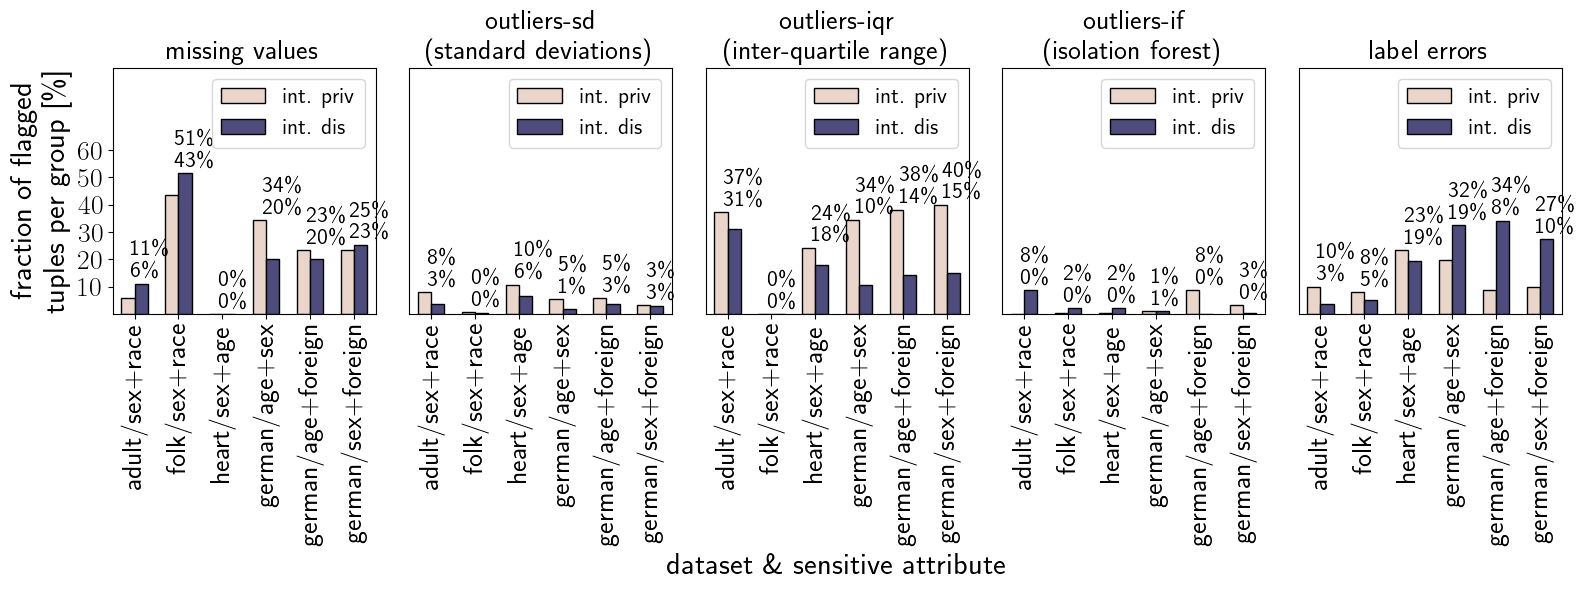

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

Generating CTE with stored snippets : 'error_rates__pp_dd'

figure_flagged-intersectional_pp_dd_age@55.pdf


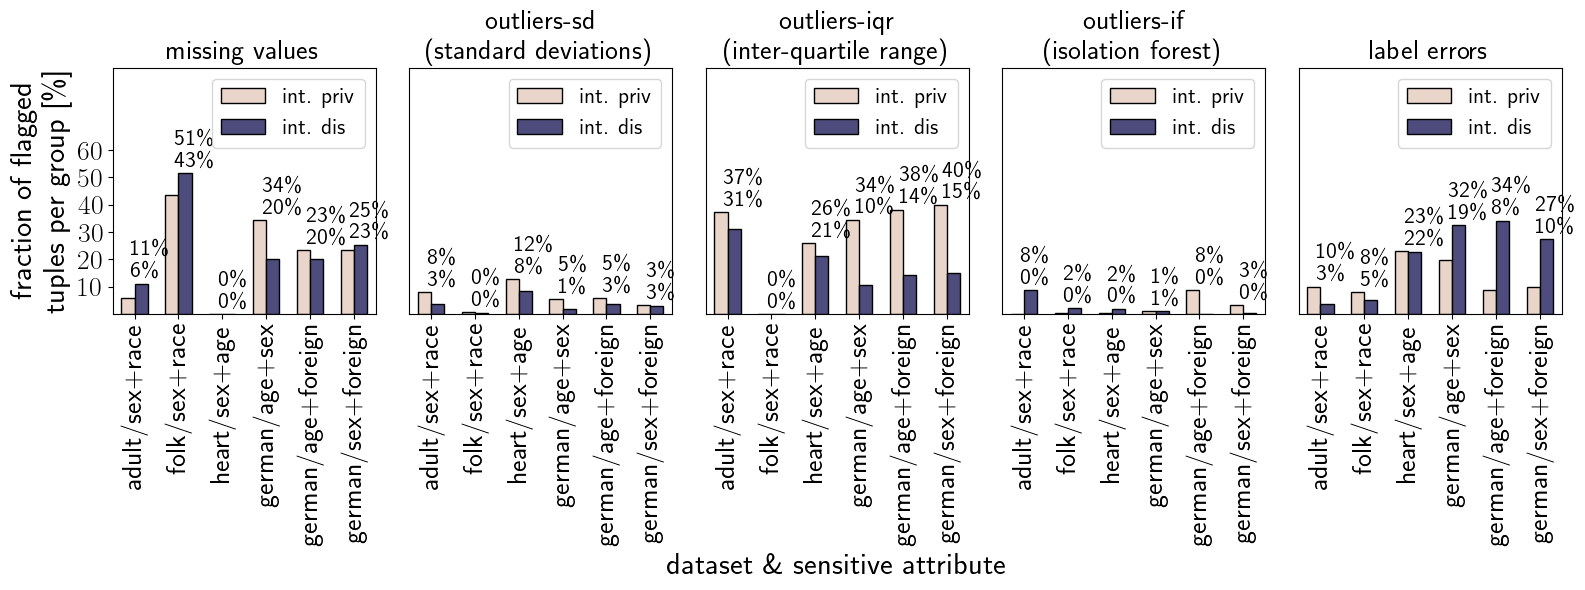

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

figure_flagged-intersectional_pagg_dd_age@45.pdf


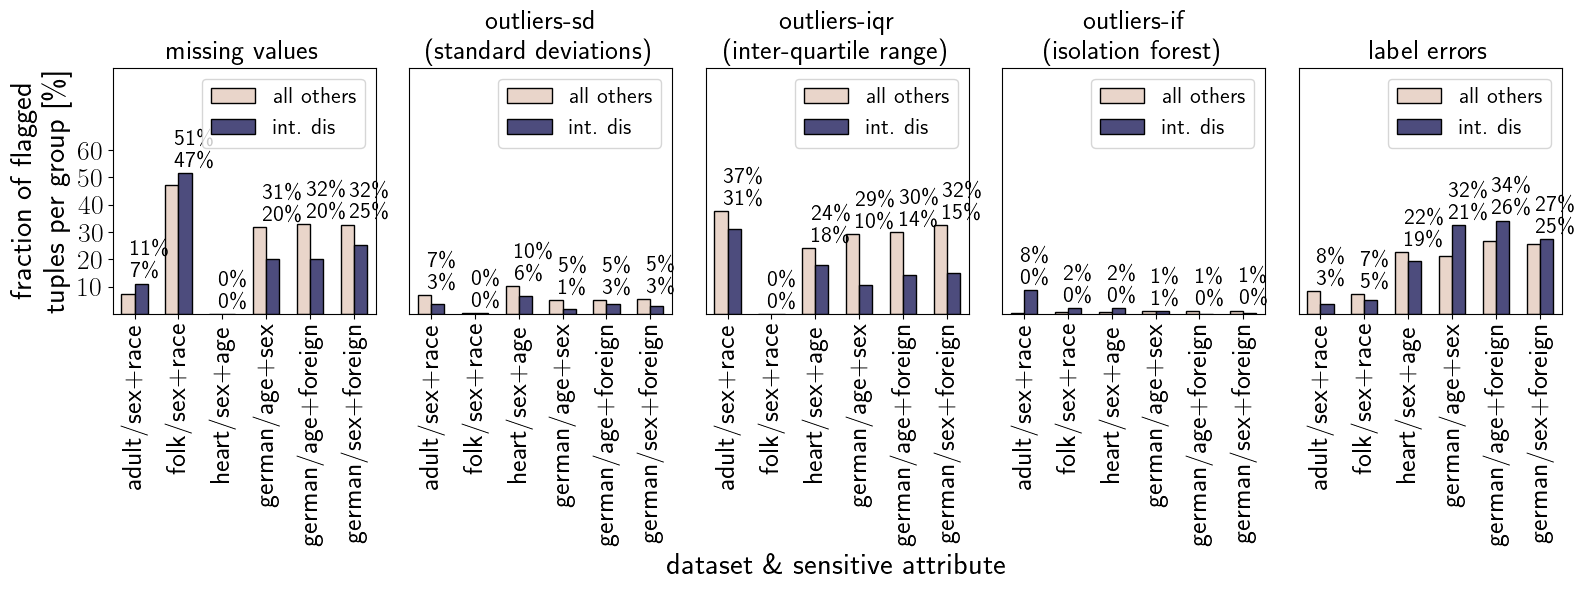

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

Generating CTE with stored snippets : 'error_rates__pagg_dd'

figure_flagged-intersectional_pagg_dd_age@55.pdf


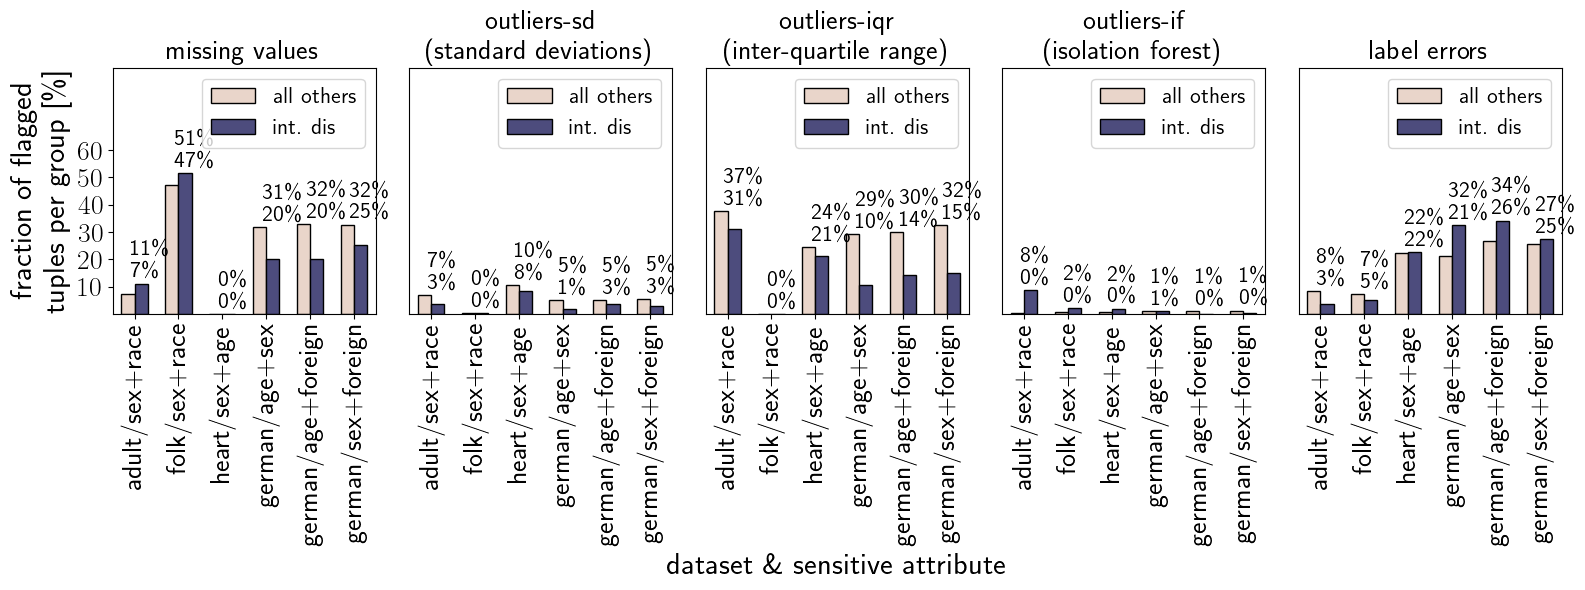

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

figure_flagged-intersectional_pp_dagg_age@45.pdf


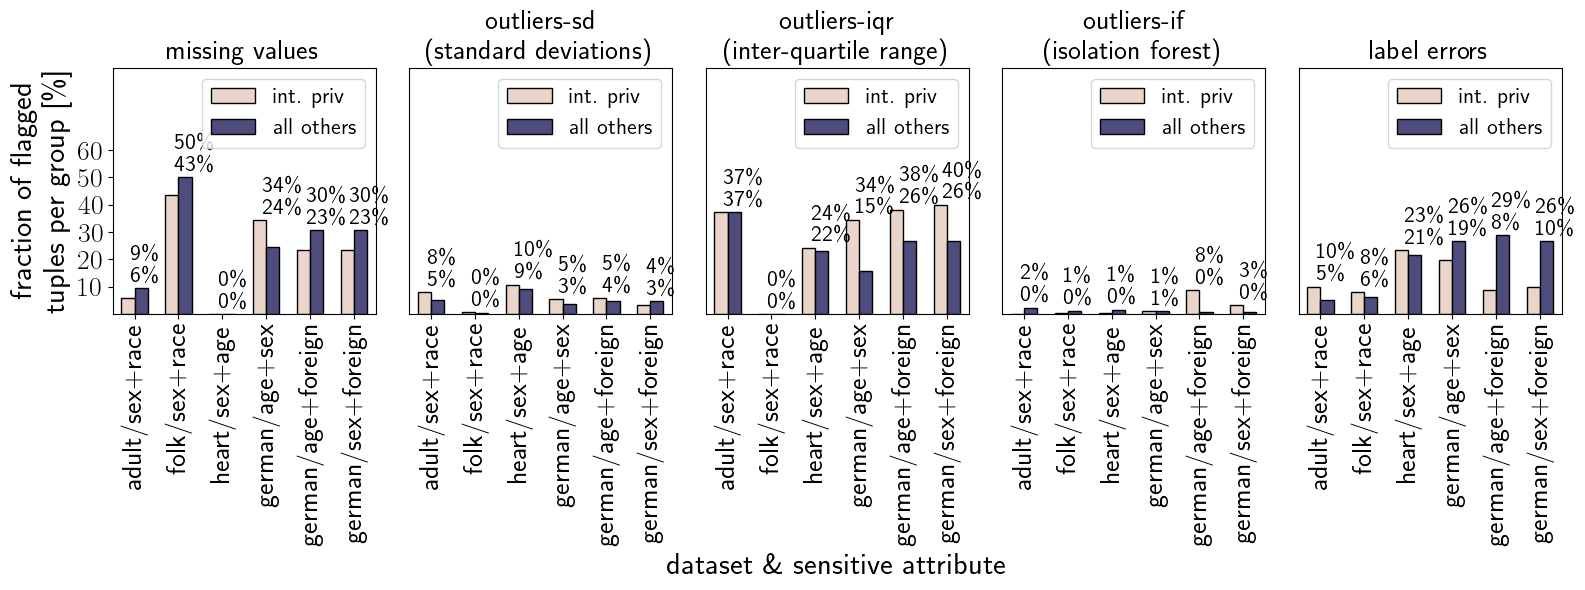

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

Generating CTE with stored snippets : 'error_rates__pp_dagg'

figure_flagged-intersectional_pp_dagg_age@55.pdf


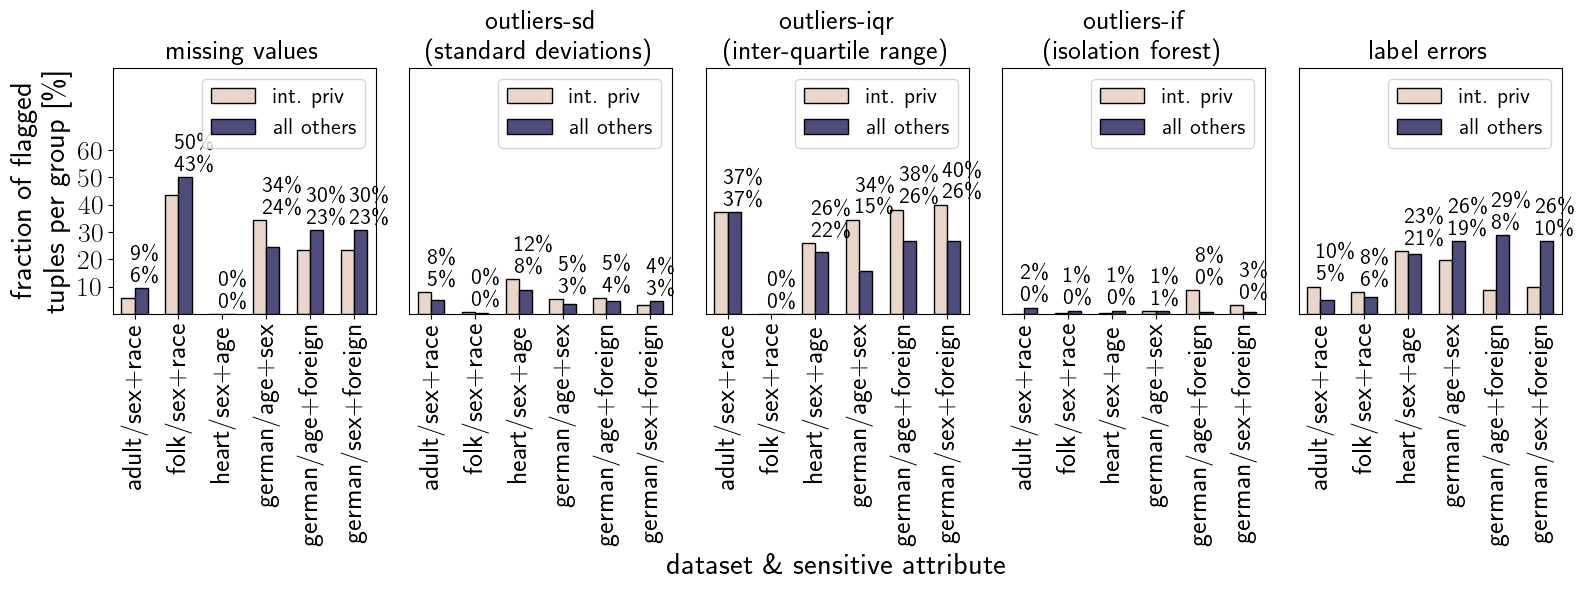

In [71]:
# intersectional_formulation = "pp_dd"  # pp vs. dd
# intersectional_formulation = "pagg_dd"  # pagg (all) vs. dd
# intersectional_formulation = "pp_dagg"  # pp vs. dagg (all)

# HEART AGE THRESHOLD
# age_threshold = "age@45"
# age_threshold = "age@55"

for intersectional_formulation in ["pp_dd", "pagg_dd", "pp_dagg"]:
    for age_threshold in ["age@45", "age@55"]:
        show_plot(intersectional_formulation, age_threshold)